In [1]:
import numpy as np
import pandas as pd
from scipy.stats import hypergeom
import matplotlib.pyplot as plt
import math
import random
from matplotlib.ticker import MaxNLocator


# Choosing n based on the margin of error

Shemilt et al. (2014) calculate the appropriate sample size using this equation for calculating the margin of error

$M\!E = z \sqrt{\frac{pi(1-pi)}{n-1}}\sqrt{1-n/1}$

where 
- z is the critical value from the normal distribution, 
- pi is the sample proportion, 
- n is the sample size, 
- N is the population size, and 
- ME is the margin of error

They use an online calculator to solve for n, but we can rearrange and implement in python

$n = \frac{N M\!E^2 + z^2Npi(1-pi)}{NM\!E^2 + pi (1-pi) z^2} $

In [2]:
def sample_size(N, pi, z, ME):
    return (N * ME**2 + z**2 * N * pi * (1-pi))/(N * ME**2 + pi * (1 -
pi) * z**2)

Given Shemilt et al.'s values for the CA review, we can recreate their sample size

In [3]:
z = 1.96
pi = 0.01
N = 804919
ME = 0.0025

n = sample_size(N, pi, z, ME)
n

6040.429453044694

Strictly speaking we should round *up* here, but this matches Shemilt et al's n=6,040.

Their actual sample proportion though was 0.000498 (3 out of 6,040)

This implies a different sample size required to get the same margin of error

In [4]:
bir = 0.000498
sample_size(N, bir, z, ME)

306.8296262317726

or, put another way, a different error margin, if we go back to the original equation and plug in the actual observed proportion

In [5]:
def error_margin(z, pi, n, N):
    return z*np.sqrt(pi*(1-pi)/(n-1))*np.sqrt(1 - n/N)

ME_hat = error_margin(z, bir, n, N)
ME_hat

0.00056056879257779

Their actual margin of error was lower than their target, but is still larger than their estimate (this means their margin of error includes 0 and a value more than twice as high as their estimate

In [6]:
estimate = round(bir*N)
print(f"estimate: {estimate}")
print(f"margin of error: {ME_hat*N}")
est_range = max(0, (bir-ME_hat)*N),(bir+ME_hat)*N
print(f"range: {est_range}")

estimate: 401
margin of error: 451.2124719529221
range: (0, 852.0621339529222)


The reason this small seeming margin of error (0.0006) gives such a wide range of actual values is because the estimate is also small.

A more sensible strategy might be to construct a margin of error bounded to within 5% of the estimated number of relevant results

$ M\!E = \frac{0.05piN}{N} $

In [7]:
def appropriate_me(pi, N):
    return pi*N*0.05/N

ME_adj = appropriate_me(bir,N)
f"{ME_adj:f}"

'0.000025'

If we substitute this into our equation for estimating the appropriate sample size, we get a very large sample

In [8]:
f"{sample_size(N, bir, z, ME_adj):n}"

'638323'

Which tells us that, when properly accounting for uncertainty, this isn't a method that promisises to save a lot of time. Further, if we overestimate by just one document, we won't save any time at all.

# Simulating a sample to estimate BIR
Now we run a small experiment where we assume that the BIR found in the Shemilt study was the actual proportion of relevant studies in the database, and pick random samples

In [9]:
population = round(N*bir)*[1] + round(N*(1-bir))*[0] # our population is made up of N*BIR ones and n*(1-BIR) zeros
data = []
iterations = 10000
for i in range(10000):
    sample = random.sample(population,math.ceil(n))
    x = sum(sample)
    pi_est = x/math.ceil(n) 
    ME_est = error_margin(z, pi_est, n, N)
    data.append({
        "x":x,
        "pi_est": pi_est,
        "ME_est": ME_est
    })

In [10]:
df = pd.DataFrame.from_dict(data)
df['X'] = round(df['pi_est']*N)
df['error'] = df['ME_est']*N
df.head()

,x,pi_est,ME_est,X,error
0,0,0.000000,0.000000,0.0,0.000000
1,2,0.000331,0.000457,266.0,367.928362
2,3,0.000497,0.000560,400.0,450.581064
3,3,0.000497,0.000560,400.0,450.581064
4,6,0.000993,0.000791,799.0,637.059530


0.2228
0.3558


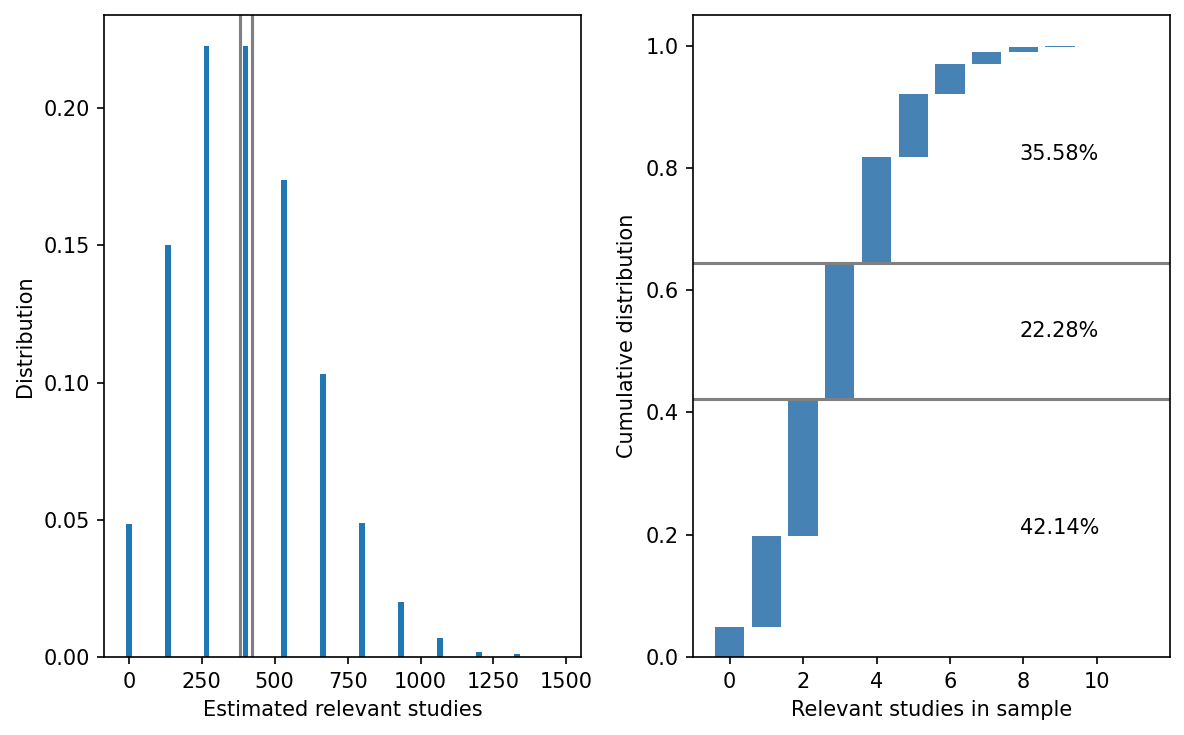

In [11]:
fig, axs = plt.subplots(1,2, figsize=(8,5),dpi=150)
ax = axs[0]
counts = df.groupby('X')['X'].count()
ax.bar(counts.index,counts/iterations,width=20)
ax.axvline(round(N*bir)*0.95, c="grey")
ax.axvline(round(N*bir)*1.05, c="grey")
ax.set_xlabel("Estimated relevant studies")
ax.set_ylabel("Distribution")

ax = axs[1]

ax.set_xlabel("Relevant studies in sample")
ax.set_ylabel("Cumulative distribution")
b=0
for i,x in df.groupby('x')['x']:
    x = x.count()/iterations
    ax.bar(i,x,bottom=b,color="steelblue")
    if i==round(n*bir):
        ax.axhline(b, color="grey",)
        ax.axhline(b+x, color="grey",)
        ax.text(df['x'].max()*0.718,b*0.5,f"{b:.2%}",va="center")
        ax.text(df['x'].max()*0.718,b+x*0.5,f"{x:.2%}",va="center")
        ax.text(df['x'].max()*0.718,b+x+(1-(b+x))*0.5,f"{1-(b+x):.2%}",va="center")
        print(x)
        print(1-(b+x))
    b+=x
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
fig.tight_layout()

This is not so useful as it implies that we only get the estimate right 22.5% of the time. 39.7% of the time we underestimate (meaning that our recall if we stopped screening when we reached our estimated number of relevant documents would be no greater than 66.6%, and as low as 0%). 37.8% of the time our estimate is above the true value, meaning that we wouldn't save any time, because we would never reach our target number.


This follows the hypergeometric distribution, which tells us the probability of drawing $k$ successes (relevant documents) in a sample of $n$ drawn without replacement from a population of $N$ documents with $K$ successes. Incidentally this is a more suitable tool for understanding uncertainty with this class of problem, and it is what we use in the rest of this paper.

3.0015442547635227
0.42194385774178944


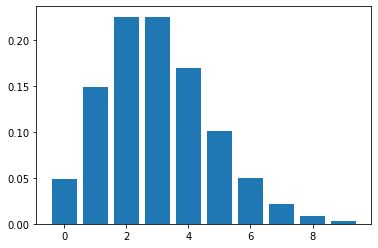

In [12]:
# with numbers from Shemilt:
# case 1: N = 804 919, n = 6040, estimated relevant 400
rate = 400/804919
mean_results =  6040 * rate
print(mean_results) # -> found 3 relevant studies in sample
print(hypergeom.cdf(2,  804919, 6040, 400))
fig = plt.figure()
x = np.arange(10)
plt.bar(x, hypergeom.pmf(x, 804919, 6040, 400))
plt.show()

In [16]:
20000*0.025

500.0

Now we can imagine a sligtly easier dataset with 20,000 documents, of which 2.5\% are relevant.

That means we have 500 relevant documents, which we refer to as $\rho_{tot}$

We imagine that we are going to stop screening once we get to what we think is 95\% of relevant documents

We have two types of error, which we show below for a sample of 1,000 documents:

- underestimating, by even 1 single document, the number of relevant documents, which results in achieving a recall below 95\% **yellow**
- overestimating, by more than $\frac{\rho_{tot}}{.95}-\rho_{tot}$ documents, the number of relevant documents, which results in zero work savings **blue**

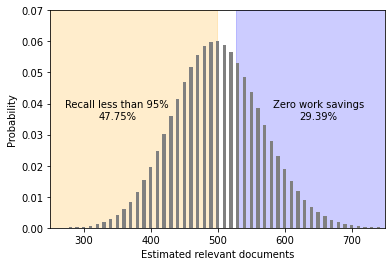

In [23]:
fig, ax = plt.subplots()
sample_size = 2000
total_number_items = 20000
type1_items = 500
bir = type1_items/total_number_items

sample_type1 = np.arange(0, sample_size + 1)

pmf_array = hypergeom.pmf(sample_type1, total_number_items, sample_size, type1_items)
r_est = sample_type1 * total_number_items / sample_size
est_points = np.column_stack((r_est, pmf_array))

data = np.transpose(est_points)

ax.axvspan(0, type1_items-1, alpha=0.2, color='orange')
ax.axvspan(math.ceil(type1_items/0.95), 1000, alpha=0.2, color='blue')

ax.bar(data[0], data[1], width = 5, color = 'grey', alpha=1)
ax.vlines([950, 1000], 0, 0.05)

ax.text(650, 0.035,f"Zero work savings\n{hypergeom.sf(math.ceil(type1_items/.95*0.1), total_number_items, sample_size, type1_items):.2%}",ha="center")

ax.text(350, 0.035,f"Recall less than 95%\n{hypergeom.cdf(type1_items*0.1-1, total_number_items, sample_size, type1_items):.2%}",ha="center")

ax.set_xlim([250,750])
ax.set_ylim([0, 0.07])

ax.set_xlabel('Estimated relevant documents')
ax.set_ylabel('Probability')

plt.savefig("../images/bir_errors.pdf")


In [33]:
100-47.75-29.39

22.86

We can show how the distribution of these errors changes as we increase the sample size

In [30]:

e1s = []
e2s = []

for n in range(1,round(total_number_items*0.5)+1):
    x = round(n*bir)
    max_miss = math.floor(type1_items*((n)/total_number_items)-1)
    min_miss = math.ceil((type1_items/0.95)*((n)/total_number_items))
    e1s.append(hypergeom.cdf(max_miss, total_number_items, n, type1_items))
    e2s.append(hypergeom.cdf(min_miss-1, total_number_items, n, type1_items))
    

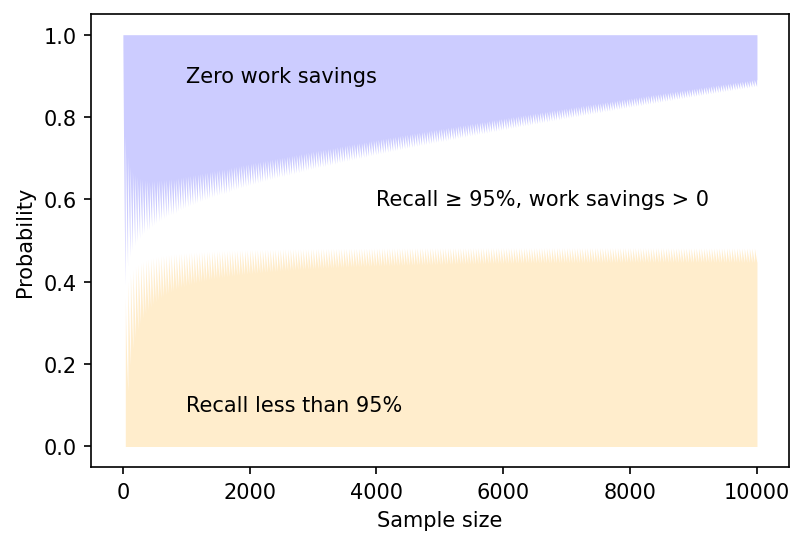

In [32]:
fig, ax = plt.subplots(dpi=150)
ax.fill_between(x=np.arange(1,n+1),y1 = np.array(e1s), y2=0, color="orange", alpha=0.2, lw=0)
ax.fill_between(range(1,n+1),e2s, y2=1, color="blue",alpha=0.2, lw=0)

ax.set_xlabel('Sample size')
ax.set_ylabel('Probability')

ax.text(1000, 0.9,f"Zero work savings",ha="left",va="center")

ax.text(4000, 0.6,f"Recall ≥ 95%, work savings > 0",ha="left",va="center")

ax.text(1000, 0.1,f"Recall less than 95%",ha="left",va="center")

plt.savefig('../images/bir_error_distribution.pdf')
plt.show()